# Building our own Face Detection model

This model comes with...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import glob
import pickle
import tqdm

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms

from PIL import Image

In [11]:
class FaceDetection_dataset(Dataset):
    def __init__(self, imgset_face:list, imgset_noface:list, val_stride:int=0, isValSet_bool:bool=False, 
                 isAugment_bool:bool=False, isNormalize_bool:bool=False):
        """
        Class that build the dataset to feed the Pytorch Dataloader 

        -------------------
        Class attributs:
            imgset_face: list of PIL images
                The list of PIL images with face in it
            imgset_face: list of PIL images.
                The list of PIL images without face in it (typically random
                background found in the 'houseroom dataset').
            val_stride: int
                Use to select training images and validation images without data
                leaks.
            isValSet_bool: bool
                Boolean to construct a validation dataset
            isAugment_bool: bool
                Boolean to activate the data augmentation preprocessing
            isNormalize_bool: bool
                Boolean to activate normalization of each image by its own mean
                and std values.
        """
        
        self.isAugment_bool = isAugment_bool
        self.isNormalize_bool = isNormalize_bool
        
        self.imgset = imgset_face + imgset_noface        
        
        label_face = np.ones(len(imgset_face)).tolist()
        label_noface = np.zeros(len(imgset_noface)).tolist()
        self.labelset = label_face + label_noface
        
        if isValSet_bool:
            assert val_stride > 0, 'val_stride should be greater than zero'
            self.imgset = self.imgset[::val_stride]
            self.labelset = self.labelset[::val_stride]
       
        elif val_stride > 0:
            del self.imgset[::val_stride]
            del self.labelset[::val_stride]

    def preprocess(self, img)->torch.Tensor:
        transform = torchvision.transforms.Compose(
            [torchvision.transforms.Resize((256)), 
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225])])
        img_t = transform(img)
        
        if self.isAugment_bool:
            """ to do """
            augment = torchvision.transforms.Compose([
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.RandomRotation(degrees=(-10,10))
            ])
            img_t = augment(img)
        

        if self.isNormalize_bool:
            mean, std = img_t.mean(), img_t.std()
            img_t = (img_t - mean) / std

        return img_t



    def __len__(self):
        return len(self.imgset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.imgset[idx]
        image = self.preprocess(image)
        
        label = self.labelset[idx]
            
        return image, torch.tensor(label, dtype=torch.int32)


# Loading data

In [12]:
### https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset
### http://vis-www.cs.umass.edu/lfw/

data_path = '/content/drive/MyDrive/Colab Notebooks'

#----------------------------- Loading images with a face ---------------------#
#imgset_face_path = glob.glob(data_path + '/face_verification/*dataset/*lfw/*/*')
#imgset_face_PIL = [Image.open(k).convert('RGB') for k in imgset_face_path]
with open(data_path + '/face_verification/dataset/dataset_augmented/lfw_PIL.pkl', 'rb') as lfw_PIL:
    imgset_face_PIL = pickle.load(lfw_PIL)


#----------------------------- Loading images without face --------------------#
#imgset_noface_path = glob.glob(data_path + '/face_verification/*dataset/*houseroom/*/*')
#imgset_noface_PIL = [Image.open(k).convert('RGB') for k in imgset_noface_path]
with open(data_path + '/face_verification/dataset/houseroom/houseroom_3000_PIL.pkl', 'rb') as houseroom_PIL:
    imgset_noface_PIL = pickle.load(houseroom_PIL)

#----------------------------- Creating datasets ------------------------------#
dataset_train = FaceDetection_dataset(imgset_face_PIL, imgset_noface_PIL, val_stride=10, isValSet_bool=False, isAugment_bool=True)
dataset_val = FaceDetection_dataset(imgset_face_PIL, imgset_noface_PIL, val_stride=10, isValSet_bool=True)

del imgset_face_PIL, imgset_noface_PIL

#----------------------------- Creating loaders -------------------------------#
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

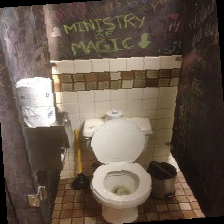

In [24]:
import random as rd
rd.choice(dataset_train)[0]

# Creating the model

In [ ]:
res50 = torchvision.models.resnet50(pretrained = True, progress = True)

### Freezing all weights
for param in res50.parameters():
  param.requires_grad = False

### Turning the last fc layer such that it has 2 outputs
res50.fc = nn.Linear(2048, 2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

optimizer = torch.optim.SGD(res50.parameters(), lr=0.01)
num_epochs = 2

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Building the training loop function

In [ ]:
def model_loop(model, epochs, trainloader, validloader, optimizer, loss_fn, device):
    model.to(device)
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} on {device} \n-------------------------------")
        model.train()
        train_loss = 0.0
        size = len(trainloader.dataset)
        
        for batch, (data, labels) in enumerate(trainloader):
            # Transfer Data to GPU if available
            data, labels = data.to(device), labels.to(device)

            # Clear the gradients
            optimizer.zero_grad()

            # Make prediction & compute the mini-batch training loss
            preds = model(data)
            loss = loss_fn(preds, labels)

            # Compute the gradients
            loss.backward()

            # Update Weights
            optimizer.step()

            # Aggregate mini-batch training losses
            train_loss += loss.item()
            train_loss_list.append(train_loss)

            
            if batch % 100000 == 0:
                loss, current = loss.item(), (batch+1) * len(data)
                print(f"mini-batch loss for training : {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        # Compute the global training loss as the mean of the mini-batch training losses
        train_loss /= len(trainloader)
      
        model.eval()
        valid_loss = 0.0
        # Test part : no gradient update
        with torch.no_grad():
            for batch, (data, labels) in enumerate(validloader):
                # Transfer Data to GPU if available
                data, labels = data.to(device), labels.to(device)
              
                # Forward Pass & compute the mini-batch validation loss
                preds = model(data)
                loss = loss_fn(preds,labels)

                # Calculate Loss
                valid_loss += loss.item()
                valid_loss_list.append(valid_loss)

                if batch % 10 == 0:
                    loss, current = loss.item(), (batch+1) * len(data)
                    print(f"mini-batch loss for validation : {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        # Compute the global validation loss as the mean of the mini-batch validation losses
        valid_loss /= len(validloader)

        print(f"Epoch {epoch+1} \n Training Loss: {train_loss:>7f} \n Validation Loss: {valid_loss:>7f}" )

    return train_loss_list, valid_loss_list


# Training

In [ ]:
loss = nn.CrossEntropyLoss()
train_loss, valid_loss = model_loop(model = res50,
                                    epochs = num_epochs,
                                    trainloader=train_dataloader,
                                    validloader = val_dataloader,
                                    optimizer=optimizer,
                                    loss_fn = loss,
                                    device = device) 

Epoch 1 on cpu 
-------------------------------
mini-batch loss for training : 0.726754  [  128/ 6814]
mini-batch loss for validation : 0.000223  [  128/ 6814]
Epoch 1 
 Training Loss: 0.044923 
 Validation Loss: 0.000698
Epoch 2 on cpu 
-------------------------------
mini-batch loss for training : 0.001566  [  128/ 6814]
mini-batch loss for validation : 0.000216  [  128/ 6814]
Epoch 2 
 Training Loss: 0.000325 
 Validation Loss: 0.000815


In [ ]:
losses = {'train_loss' : train_loss, 'valid_loss' : valid_loss}
import pickle
with open("losses.pickle", "wb") as file:
    pickle.dump(losses, file)


In [ ]:
def test_accuracy(model, validloader, device):
    correct = 0
    total = len(validloader.dataset)
    model.eval()

    # test part : no gradient update
    with torch.no_grad():
        for imgs, labels in validloader :
            # Transfer Data to GPU if available
            imgs, labels = imgs.to(device), labels.to(device)

            # Prediction on unseen data as 0 or 1
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)

            # Aggregate and sum the correct predictions for each mini-batch
            correct += int((predicted == labels).sum())

    # Mean of the mini-batch correct predictions
    accuracy = correct / total
    print("Validation accuracy : {:.2f}".format(accuracy))

In [ ]:
test_accuracy(res50, val_dataloader, device)

NameError: ignored

In [ ]:
img_de_moi = glob.glob(data_path + '/*dataset/*jpg')
img_de_moi

['/content/drive/MyDrive/Colab Notebooks/dataset/moi_sombre.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dataset/moi_bas_eclaire.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dataset/moi_ok.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dataset/pasmoi_1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dataset/pasmoi_2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dataset/pasmoi_3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dataset/pasmoi_4.jpg']

In [ ]:
preprocess = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225]),
            ])

pred_list = []
img_pred_list = []
for k in img_de_moi :
  with torch.no_grad():
    img = Image.open(k)
    img_t = preprocess(img)
    img_gpu = img_t.to(device)
    pred = res50(img_gpu.unsqueeze(0))
    _, img_pred = torch.max(pred, dim=1)
    img_pred_list.append(img_pred)
    pred_list += pred

img_pred_list

[tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0')]

In [ ]:
img_test = dataset_val[5][0].unsqueeze(0).to(device)
a = torchvision.transforms.ToPILImage()(img_test.squeeze(0))
a.show()

In [ ]:
torch.save(res50, data_path + '/res50_face_detection_2.pth')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open('losses.pickle', 'rb') as pkl:
    losses = pickle.load(pkl)

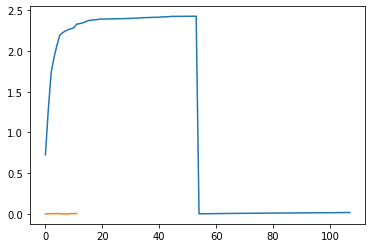

In [ ]:
train_loss = losses['train_loss']
valid_loss = losses['valid_loss']

train_loss_a = np.array(train_loss)
valid_loss_a = np.array(valid_loss)

plt.plot(train_loss_a)
plt.plot(valid_loss_a)

In [ ]:
train_loss_a

array([7.26754189e-01, 1.27096283e+00, 1.72886929e+00, 1.91742384e+00,
       2.06040400e+00, 2.19214158e+00, 2.22320805e+00, 2.24446922e+00,
       2.26210658e+00, 2.27291502e+00, 2.28503628e+00, 2.32956765e+00,
       2.33472416e+00, 2.34417710e+00, 2.35653077e+00, 2.37167861e+00,
       2.37641066e+00, 2.38186004e+00, 2.38256879e+00, 2.39096806e+00,
       2.39144261e+00, 2.39199617e+00, 2.39278914e+00, 2.39347116e+00,
       2.39384132e+00, 2.39415927e+00, 2.39570596e+00, 2.39635188e+00,
       2.39771858e+00, 2.39805939e+00, 2.39903542e+00, 2.40264012e+00,
       2.40316140e+00, 2.40353961e+00, 2.40833454e+00, 2.40895863e+00,
       2.40954224e+00, 2.41138165e+00, 2.41284637e+00, 2.41322967e+00,
       2.41341100e+00, 2.41832886e+00, 2.41856607e+00, 2.41924852e+00,
       2.42359686e+00, 2.42410438e+00, 2.42441930e+00, 2.42464649e+00,
       2.42509494e+00, 2.42522560e+00, 2.42538189e+00, 2.42555796e+00,
       2.42563661e+00, 2.42585543e+00, 1.56572997e-03, 1.79192632e-03,
      

In [ ]:
res18 = torchvision.models.resnet18(pretrained = True, progress = True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
res18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
res18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  